### Linear Regression Models 

In [2]:
df <- read.table('lowbwt.dat', header=TRUE)

In [3]:
#lowercase the col names
names(df) <- tolower(names(df))
# Check the data
head(df,3)
# Check the dim
dim(df)

,id,low,age,lwt,race,smoke,ptl,ht,ui,ftv,bwt
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,85,0,19,182,2,0,0,0,1,0,2523
2,86,0,33,155,3,0,0,0,0,3,2551
3,87,0,20,105,1,1,0,0,0,1,2557


[1] 189  11

In [4]:
# See the structure of the dataset
str(df)
# R believes everything is a variable. race shouldnt be an int
# See summary
summary(df)

'data.frame':	189 obs. of  11 variables:
 $ id   : int  85 86 87 88 89 91 92 93 94 95 ...
 $ low  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ age  : int  19 33 20 21 18 21 22 17 29 26 ...
 $ lwt  : int  182 155 105 108 107 124 118 103 123 113 ...
 $ race : int  2 3 1 1 1 3 1 3 1 1 ...
 $ smoke: int  0 0 1 1 1 0 0 0 1 1 ...
 $ ptl  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ ht   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ ui   : int  1 0 0 1 1 0 0 0 0 0 ...
 $ ftv  : int  0 3 1 2 0 0 1 1 1 0 ...
 $ bwt  : int  2523 2551 2557 2594 2600 2622 2637 2637 2663 2665 ...


       id             low              age             lwt       
 Min.   :  4.0   Min.   :0.0000   Min.   :14.00   Min.   : 80.0  
 1st Qu.: 68.0   1st Qu.:0.0000   1st Qu.:19.00   1st Qu.:110.0  
 Median :123.0   Median :0.0000   Median :23.00   Median :121.0  
 Mean   :121.1   Mean   :0.3122   Mean   :23.24   Mean   :129.8  
 3rd Qu.:176.0   3rd Qu.:1.0000   3rd Qu.:26.00   3rd Qu.:140.0  
 Max.   :226.0   Max.   :1.0000   Max.   :45.00   Max.   :250.0  
      race           smoke             ptl               ht         
 Min.   :1.000   Min.   :0.0000   Min.   :0.0000   Min.   :0.00000  
 1st Qu.:1.000   1st Qu.:0.0000   1st Qu.:0.0000   1st Qu.:0.00000  
 Median :1.000   Median :0.0000   Median :0.0000   Median :0.00000  
 Mean   :1.847   Mean   :0.3915   Mean   :0.1958   Mean   :0.06349  
 3rd Qu.:3.000   3rd Qu.:1.0000   3rd Qu.:0.0000   3rd Qu.:0.00000  
 Max.   :3.000   Max.   :1.0000   Max.   :3.0000   Max.   :1.00000  
       ui              ftv              bwt      
 Min.

Lets go over the variables and what exactly was measured and then well decide what to do.
There has to be some kind of preprocessing.

189 mothers gave birth. 
the birthweight of the baby is bwt. 

id has no information. 
low is an indicator variable telling if the baby was low birthweight or not (>6 lb). since we have the actual bwt, the variable lo is a discretized version or categorical version of bwt. 
its not good to have both variables in the model so we can discard this later along with id. 
Age is the age of the mom at the birth of the baby, this is a notorious variable that exhibits a nonlinear trend, especially in health related issues. theres usually a peak of health performance around 25. adding age as a continuous variable would not be right because it would imply that there is an increase or decrease in some measurement in people. 
lwt - this is the weight of the mom before pregnancy. 
race - even tho R thinks its numerical, its certainly categorical. (1 - white, 2 - black, 3 - other). we have to unconfuse R on this issue. 
smoke - indicator for smoking status. 
ptl - preterm labor - count variable for how many times the woman had labor preterm. 
ht - hypertension - high blood pressure. 
ui - irritability of the uterus - pretty prevalent
ftv - first trimester visits - count variable

Can we build a model that explains and predicts the birthweight of the baby? what are the predictors?

before we can build we need to preprocess a bit
remove the first 2 vars


In [5]:
df <- df[,-c(1,2)]

In [6]:
# see what the disn of values for the count variables
summary(factor(df$ptl)) # 159 women had 0 preterm labor events..
# We should just create 2 categories, 0 and 1+, since theres 
# not many in the other cats
# df$ptl <- apply(df$ptl, 


0   1   2   3 
159  24   5   1

In [7]:
summary(factor(df$ftv)) 
# we didnt want to keep it as numerical cuz it would imply 
# that each visit is associated with some increase/decrease in weight
# 3 categories seems good, 0, 1, 2+


0   1   2   3   4   6 
100  47  30   7   4   1

In [8]:
# 33 min 
# Distribution of ladies axs the races
summary(factor(df$race)) 
# R thinks this is a numerical variable rn, so it would try to fit a linear trend to the 1,2,and 3s
df <- within(df, {race.cat=factor(race, 
                                 levels=1:3, 
                                 labels=c("White", "AA", "Other"))
                 ftv.cat=cut(ftv,
                               breaks=c(-Inf,0,1,Inf),
                               labels=c("None", "Normal", "Many"))
                 ptl.cat=factor(ptl>=1, 
                               levels=c(F,T),
                               labels=c("0", "1+"))
                race=NULL
                ftv=NULL
                ptl=NULL
                })

1  2  3 
96 26 67

In [9]:
head(df, 2)

,age,lwt,smoke,ht,ui,bwt,ptl.cat,ftv.cat,race.cat
,<int>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>
1,19,182,0,0,1,2523,0,None,AA
2,33,155,0,0,0,2551,0,Many,Other


When yes/no variables are encoded as 0 and 1, u can change to cat or not, the results will be the same. so well keep the smoke 0,1

Let's see a boxplot of the birthweight stratefied by race

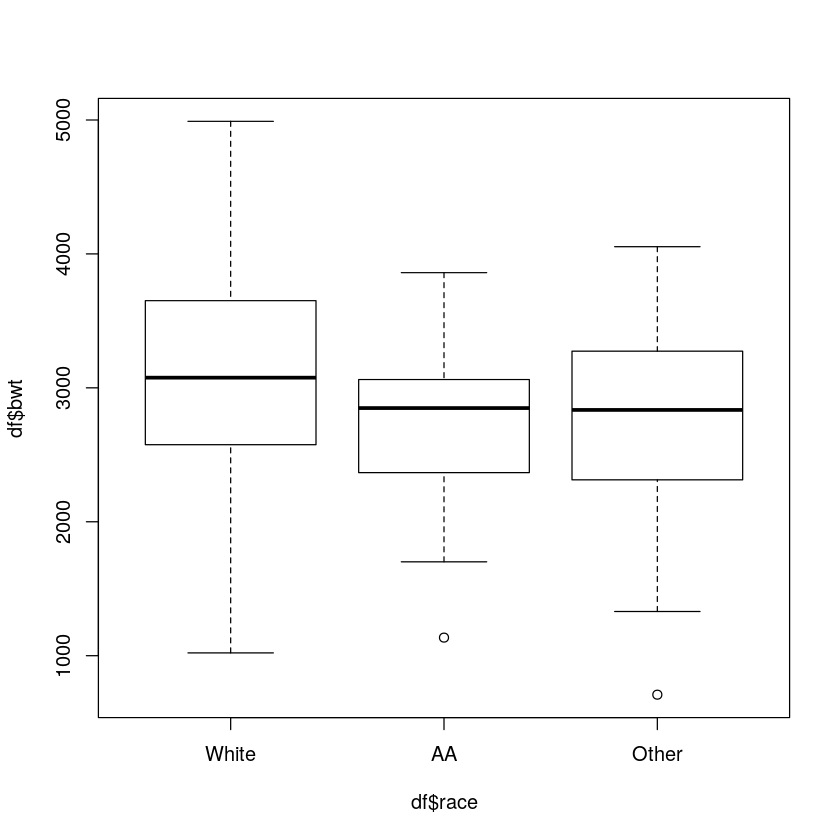

In [10]:
boxplot(df$bwt~df$race)

So now were ready to build our linear model in a stepwise fashion one variable at a time. Lets start with age. 
You have to ask for the summary or you dont get the info

In [11]:
summary(lm(bwt~age, data=df))


Call:
lm(formula = bwt ~ age, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-2294.53  -517.71    10.56   530.65  1776.27 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2657.33     238.80  11.128   <2e-16 ***
age            12.36      10.02   1.234    0.219    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 728 on 187 degrees of freedom
Multiple R-squared:  0.008076,	Adjusted R-squared:  0.002772 
F-statistic: 1.523 on 1 and 187 DF,  p-value: 0.2188


In [12]:
# Continuous age 
# 42 min
# When we look at the output, we look at the residuals: should be 0 min, and min/max shouljd be around the same with opposite signs

putting age as a linear predictor as the weight of the baby is probably the wrong way to go about it
it shows the age is not significant, but this wouldnt matter for us to answer cuz we modeled it wrong. highly nonlinear trend with a forced straight line can come back significant *** 
each additional year in age of mom would be a +12g in birthweight of baby, but this doesnt matter
R2 : the age of the mom explains less than 1% of the variability of the data, 0.008 = .8%.
F test is joint test on all the vars, so itll be the same as t if u only do one var
residual std error: variance of the error terms, which we estimated. remember the rse is used to calc the p values above, on its own were not interested but we are interested in the impact of the std error on the p values above. 

(50 min)
if we did want to use the age, wed group into cats or wed do age^2. age is notoriously nonlinear variable in health studies. 

todo* video on "linear trend" etc

In [13]:
summary(lm(bwt~lwt, data=df))


Call:
lm(formula = bwt ~ lwt, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-2192.18  -503.63    -3.91   508.25  2075.53 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept) 2369.672    228.431  10.374   <2e-16 ***
lwt            4.429      1.713   2.586   0.0105 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 718.2 on 187 degrees of freedom
Multiple R-squared:  0.03452,	Adjusted R-squared:  0.02935 
F-statistic: 6.686 on 1 and 187 DF,  p-value: 0.01048


not a major predictor at R3 = 3.45%

interpretation of weight of mum would be +4g to baby weight for each additional unit weight of mom
highly suspicious 

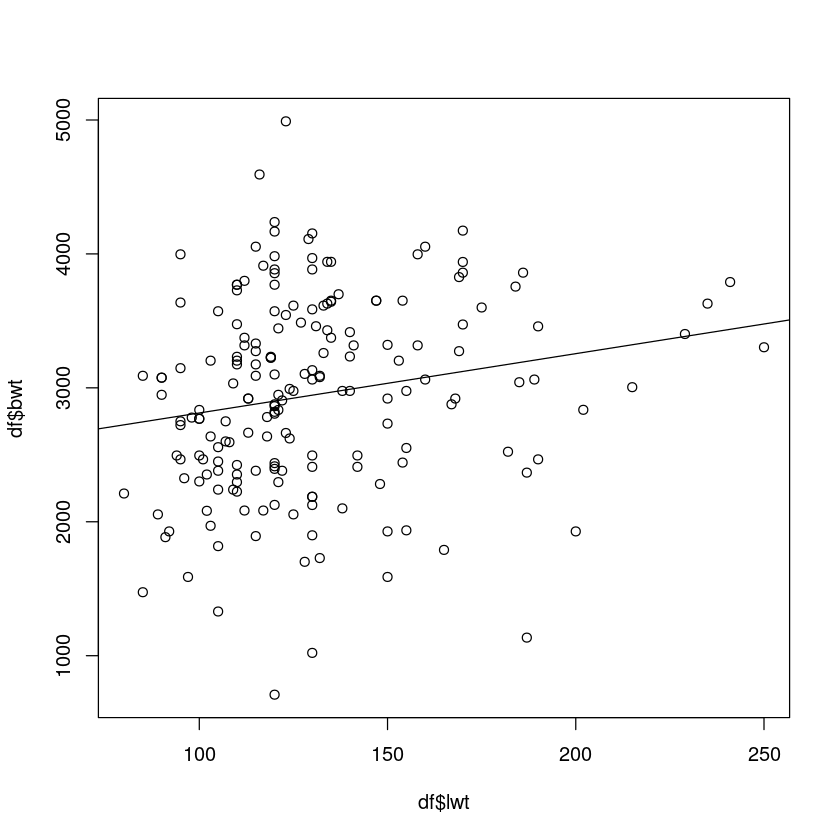

In [14]:
# boxplot(bwt~lwt, data=df)
plot(df$lwt,df$bwt)
# Not much of a correlation here even tho LM said significant
abline(lm(bwt~lwt, data=df)) # not a convincing line

small r2 implies trend hard to see

how is r2 replated to the correlation coef between the variables. 
if we square the pearson sample correlation between the variables
wed get the r2

lets go back and try to build a model again. we looked at our only 2 continuous variables. 


Call:
lm(formula = bwt ~ smoke, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-2064.24  -477.24    35.04   545.04  1935.04 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3054.96      66.93  45.642  < 2e-16 ***
smoke        -281.71     106.97  -2.634  0.00916 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 717.8 on 187 degrees of freedom
Multiple R-squared:  0.03576,	Adjusted R-squared:  0.03061 
F-statistic: 6.936 on 1 and 187 DF,  p-value: 0.009156


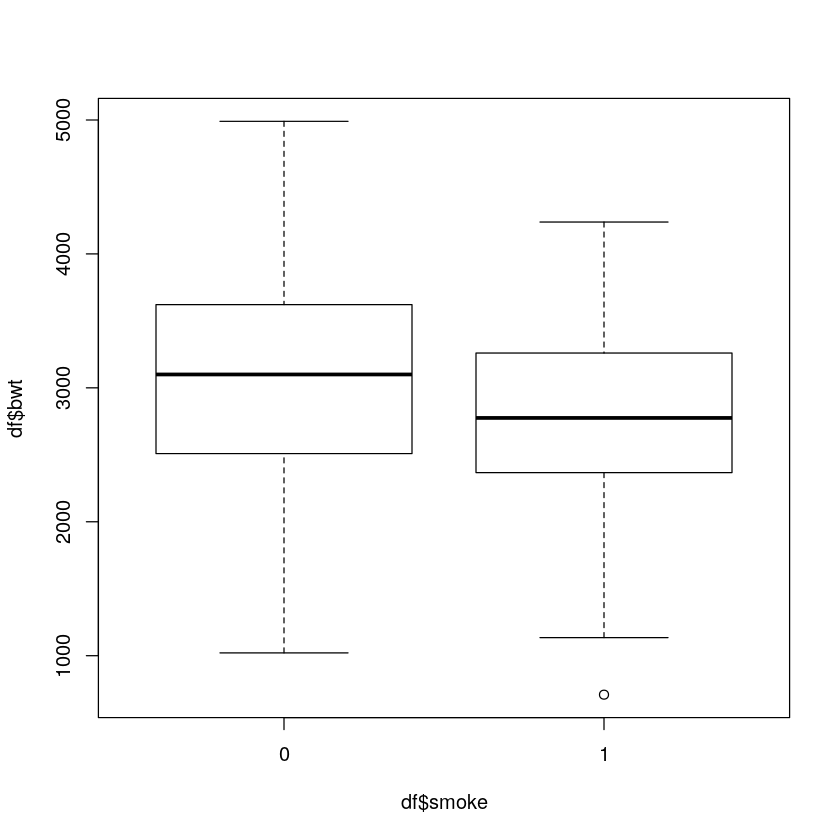

In [15]:
boxplot(df$bwt~df$smoke)
summary(lm(bwt~smoke, data=df))

interpreting the intercept: avg weight of nonsmokers moms baby
average loss of weight due to smoking is 281g
highly significant, pvalue, and relatively large effect size of 281g which is way over 1/2 lb

build model based on p value rather than r2, because the ending r2 would be more then u add all the vars together
(64 min)*

In [16]:
summary(lm(bwt~ui, data=df))


Call:
lm(formula = bwt ~ ui, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1895.61  -535.61    31.39   555.39  1959.39 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3030.61      55.25  54.857  < 2e-16 ***
ui           -580.18     143.53  -4.042 7.73e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 701 on 187 degrees of freedom
Multiple R-squared:  0.08035,	Adjusted R-squared:  0.07544 
F-statistic: 16.34 on 1 and 187 DF,  p-value: 7.732e-05


super highly significant - very dangerous 

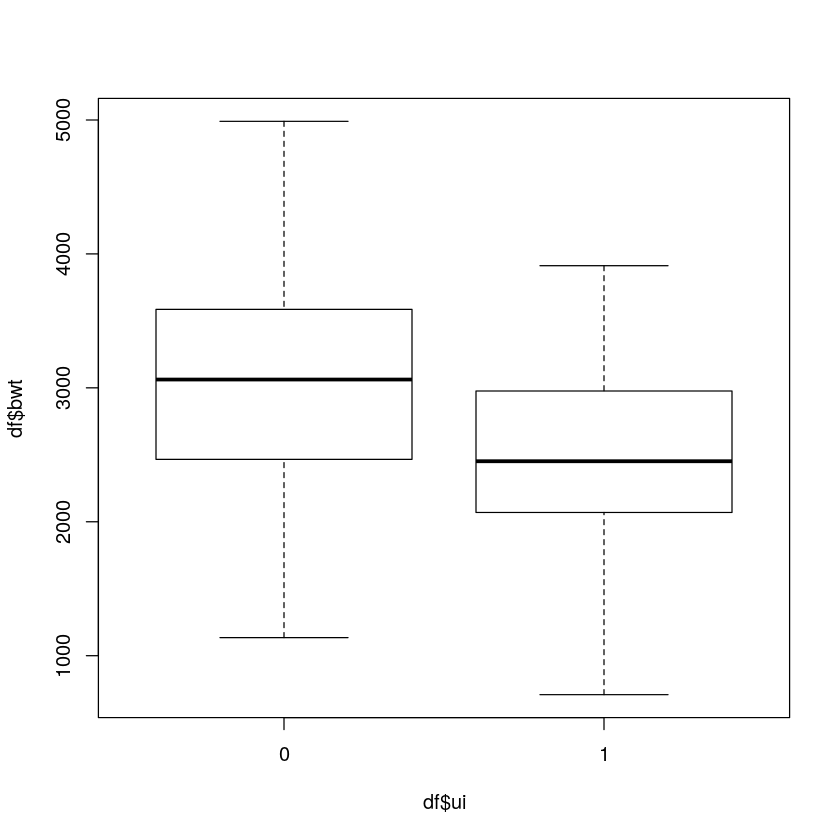

In [17]:
boxplot(df$bwt~df$ui)

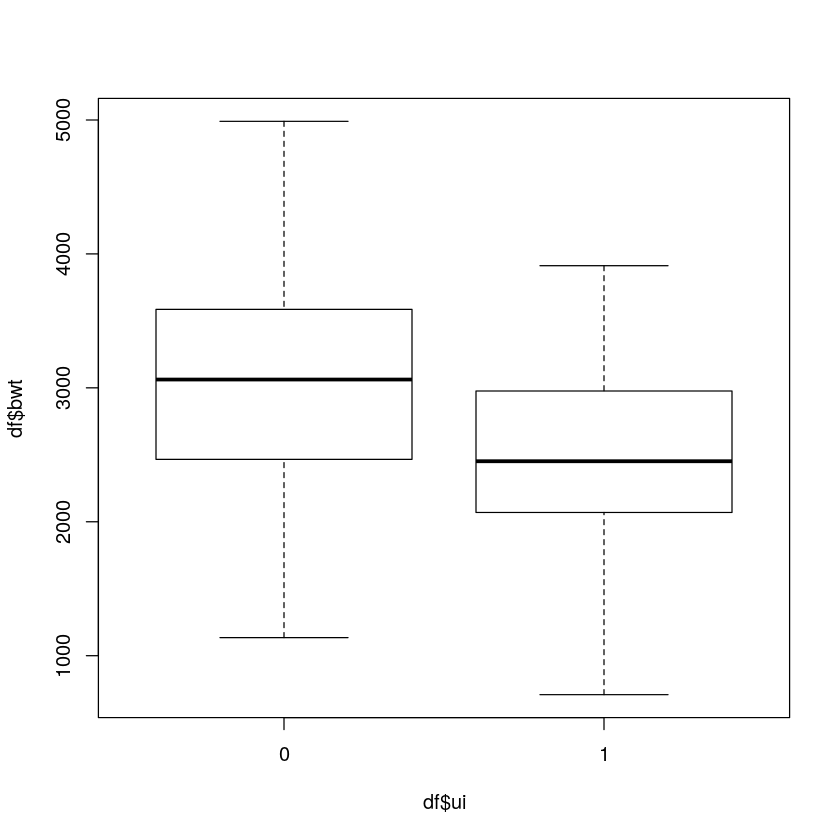

In [18]:
boxplot(df$bwt~df$ui)
# summary(lm(bwt~lwt, data=df))

<i>about compounding</i>

if a sample has both smoking and hypertension how do we know which one contibuted to the effect size

i.e. only women lived in 1 city and only men lived in another, comparing avg income, is it from area or gender, well never know cuz theyre completely compounded and cant disentangle the effect.

in our data we have one, the other, and both conditions. 

R will immediately tell u if u ask qs that the model cannot answer, will give funny result or not run (infinite sample sizes, inf std error, crash). 

Lets look at our cat vars

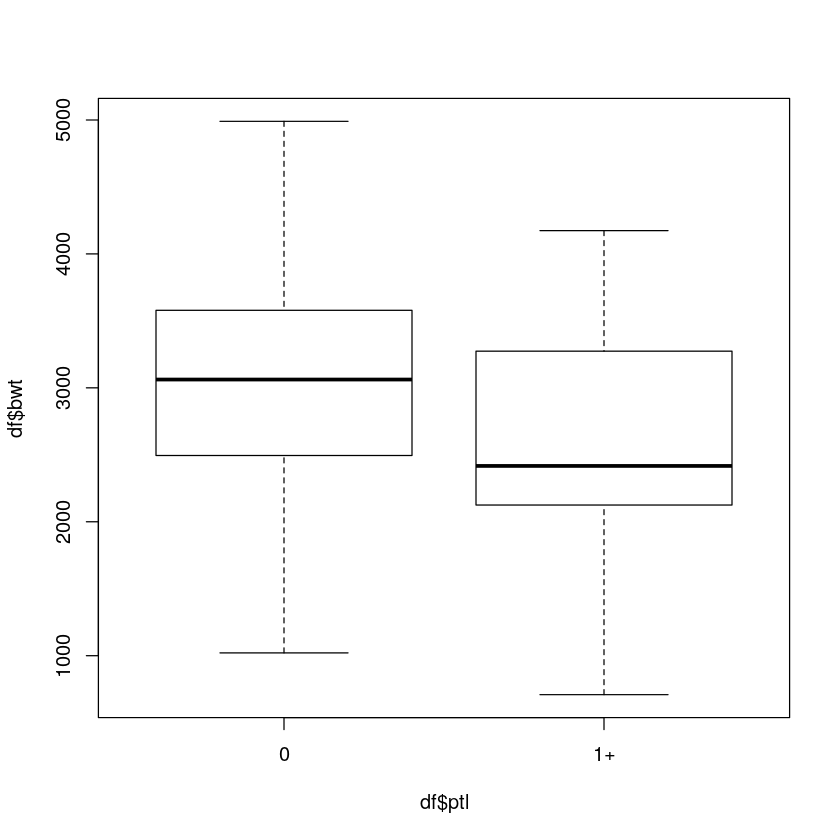

In [19]:
boxplot(df$bwt~df$ptl)

In [20]:
summary(lm(bwt~ptl.cat, data=df)) # 72 min


Call:
lm(formula = bwt ~ ptl.cat, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1992.57  -495.40    -8.57   586.43  1976.43 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3013.57      56.57  53.269  < 2e-16 ***
ptl.cat1+    -434.17     142.00  -3.058  0.00256 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 713.4 on 187 degrees of freedom
Multiple R-squared:  0.04761,	Adjusted R-squared:  0.04252 
F-statistic: 9.349 on 1 and 187 DF,  p-value: 0.002558


In [21]:
summary(lm(bwt~ftv.cat, data=df)) # 72 min


Call:
lm(formula = bwt ~ ftv.cat, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-2156.27  -484.88    26.12   578.73  1882.00 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    2865.27      72.60  39.468   <2e-16 ***
ftv.catNormal   242.73     128.39   1.891   0.0602 .  
ftv.catMany      85.61     133.49   0.641   0.5221    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 726 on 186 degrees of freedom
Multiple R-squared:  0.01887,	Adjusted R-squared:  0.008325 
F-statistic: 1.789 on 2 and 186 DF,  p-value: 0.17


In [22]:
# 77% chance that the effect size was from chance ?

In [23]:
summary(lm(bwt~race.cat, data=df)) # 75 min


Call:
lm(formula = bwt ~ race.cat, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-2095.01  -503.01   -13.74   526.99  1886.26 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    3103.74      72.88  42.586  < 2e-16 ***
race.catAA     -384.05     157.87  -2.433  0.01594 *  
race.catOther  -299.72     113.68  -2.637  0.00908 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 714.1 on 186 degrees of freedom
Multiple R-squared:  0.05075,	Adjusted R-squared:  0.04054 
F-statistic: 4.972 on 2 and 186 DF,  p-value: 0.007879


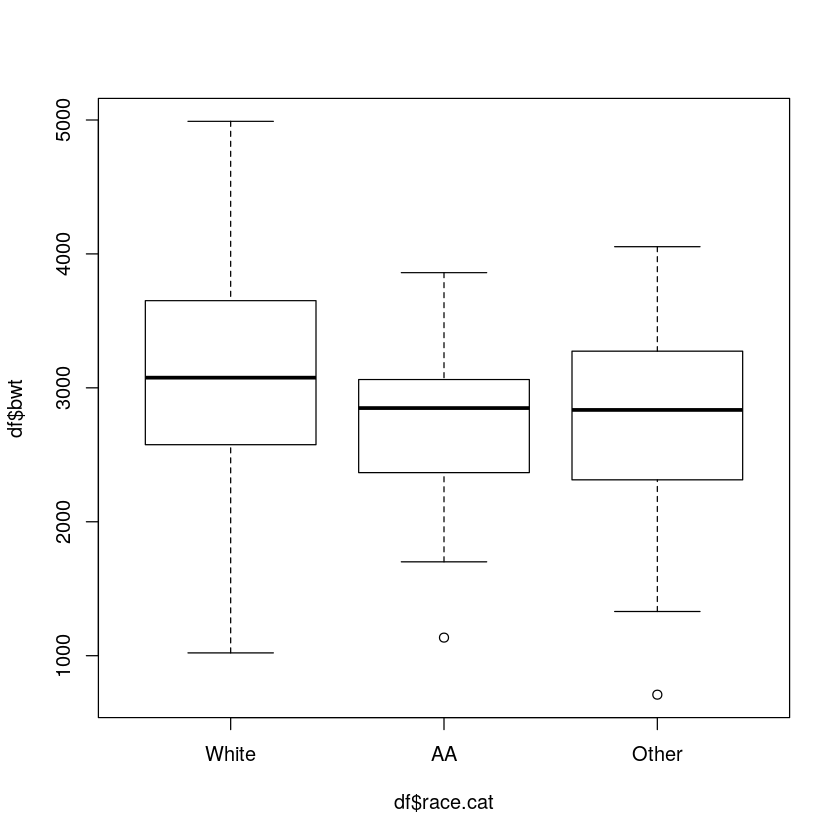

In [24]:
boxplot(df$bwt~df$race.cat)

AA and other significantly differ from baseline white category. the interpretation of the Beta0,1,2 (estimate) 

In [25]:
summary(lm(bwt~ui+ht, data=df))


Call:
lm(formula = bwt ~ ui + ht, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1741.43  -522.43    -8.38   529.62  1919.62 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3070.38      56.58  54.265  < 2e-16 ***
ui           -619.95     142.26  -4.358 2.17e-05 ***
ht           -533.63     207.25  -2.575   0.0108 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 690.7 on 186 degrees of freedom
Multiple R-squared:  0.112,	Adjusted R-squared:  0.1025 
F-statistic: 11.73 on 2 and 186 DF,  p-value: 1.593e-05


In [26]:
summary(lm(bwt~ui+ht+race.cat, data=df))


Call:
lm(formula = bwt ~ ui + ht + race.cat, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1626.55  -465.66    73.34   470.99  1778.40 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    3211.60      72.76  44.139  < 2e-16 ***
ui             -606.59     139.82  -4.338 2.36e-05 ***
ht             -493.79     203.99  -2.421   0.0165 *  
race.catAA     -364.94     150.32  -2.428   0.0162 *  
race.catOther  -269.46     108.03  -2.494   0.0135 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 677.4 on 184 degrees of freedom
Multiple R-squared:  0.155,	Adjusted R-squared:  0.1366 
F-statistic: 8.436 on 4 and 184 DF,  p-value: 2.853e-06


In [27]:
summary(lm(bwt~ui+ht+ftv.cat, data=df))


Call:
lm(formula = bwt ~ ui + ht + ftv.cat, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1697.94  -543.78    30.49   493.34  1784.34 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    3009.78      75.55  39.836  < 2e-16 ***
ui             -602.84     142.48  -4.231 3.66e-05 ***
ht             -525.31     207.86  -2.527   0.0123 *  
ftv.catNormal   195.88     122.36   1.601   0.1111    
ftv.catMany      39.73     127.43   0.312   0.7556    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 689.6 on 184 degrees of freedom
Multiple R-squared:  0.1244,	Adjusted R-squared:  0.1053 
F-statistic: 6.534 on 4 and 184 DF,  p-value: 6.136e-05


What should be the winner model? 
Compare significance and effect size 

In [28]:
summary(lm(bwt~ui+ht+ftv.cat, data=df))


Call:
lm(formula = bwt ~ ui + ht + ftv.cat, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1697.94  -543.78    30.49   493.34  1784.34 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)    3009.78      75.55  39.836  < 2e-16 ***
ui             -602.84     142.48  -4.231 3.66e-05 ***
ht             -525.31     207.86  -2.527   0.0123 *  
ftv.catNormal   195.88     122.36   1.601   0.1111    
ftv.catMany      39.73     127.43   0.312   0.7556    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 689.6 on 184 degrees of freedom
Multiple R-squared:  0.1244,	Adjusted R-squared:  0.1053 
F-statistic: 6.534 on 4 and 184 DF,  p-value: 6.136e-05


In [29]:
final_model = lm(bwt~ui+ht+lwt+race.cat+smoke, data=df)

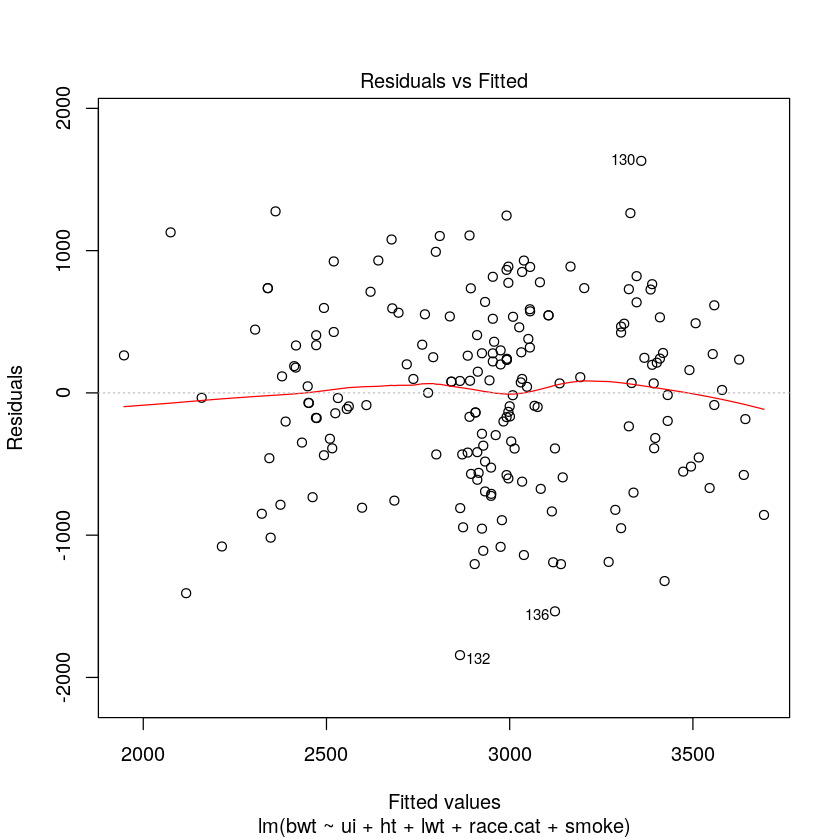

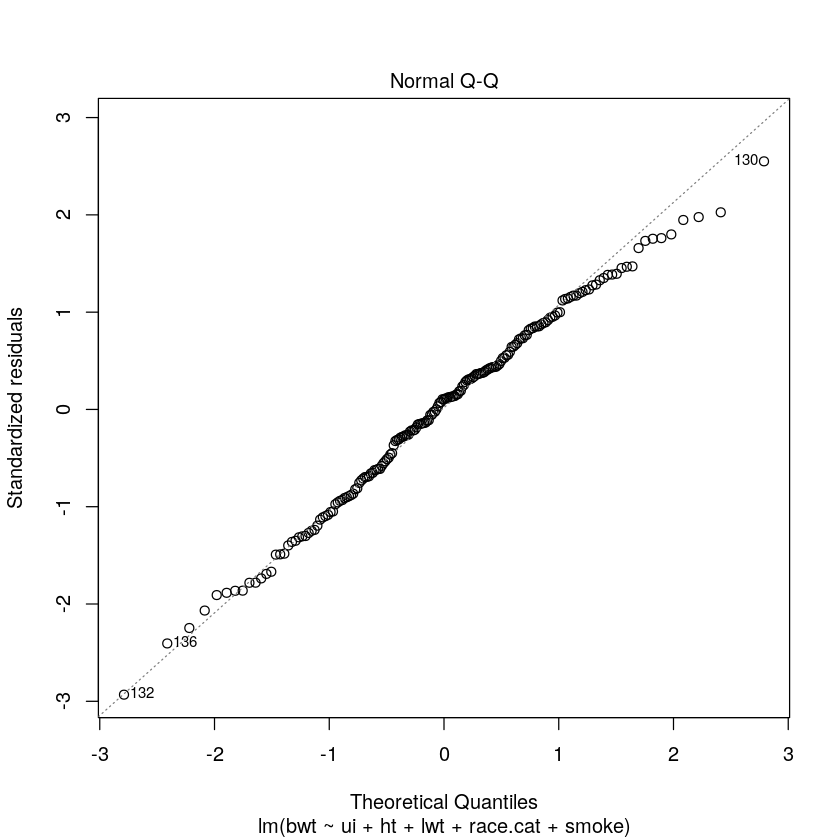

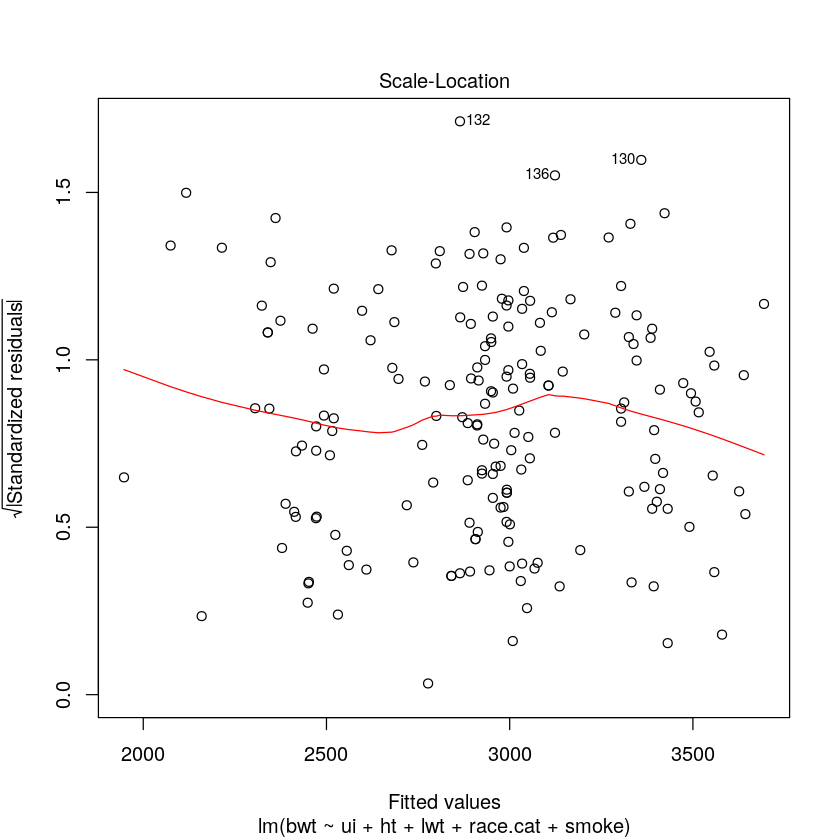

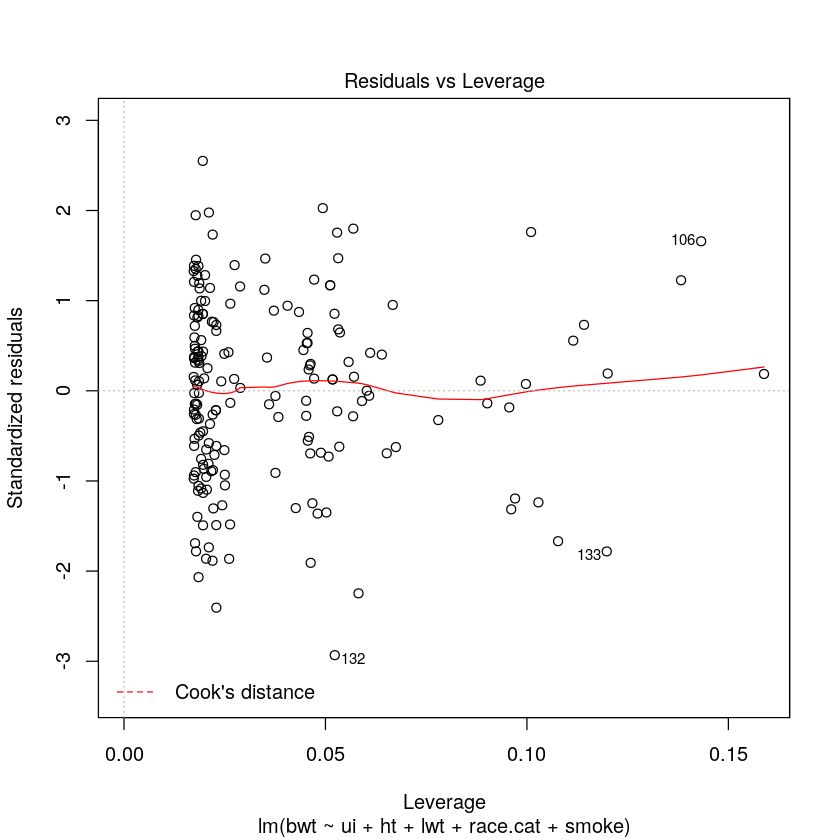

In [30]:
plot(final_model)

a good model will have very small residual variance compared to original variance of the model
(20 min)
next would be to see if theres any systematic imbalence in the model that can be reflected in the deviations of the residuals 
a bad model will have residuals that are clusters (Residuals vs fitted) and patterns in the scatter plot. this should be a random sample supposedly from a ~N disn with 0 mean and some variance. we definitely dont want to see, the larger the fitted values, the larger the 
If the red line is not flat, horizontal at 0, it would shw systematic probs in residuals.


See the std deviation to see what is a good area for residuals deviating from qq https://genome.sph.umich.edu/wiki/Code_Sample:_Generating_QQ_Plots_in_R

the red line is weighted averages (28 min), nonparametric smoothed data plot. it captures the clustering and weights and trends. average of scatterplot from left to right. perfectly balanced residuals will produce a flat line thru the middle. usually thats 0. 

scale location: y axis is sqrt of the  absolute value of the stdized residuals. mean here is 1 after transforming. 

cooks distance - (57 min) - every obs has its own cooks distance. represents 
cooks distance is related to another measure (for detection of influential observations) dffits.

leverage - h_ii, element on the main diagonal of the hat matrix *** 
leverage 

if u see an obs with a large leverage and cooks distance (exceeding 1) , we would be interested in investigating and most likely removing this point. could be considered an outlier. 

here we see no outliers in any of the measures. 

are leveraegs and cooks distance related ? yes
if you have an obs and remove it and the measurements shift a lot then it is influential

In [31]:
library(MASS)

In [32]:
# base = lm(bwt~ui+ht+lwt+race.cat+smoke, data=df)
base = lm(bwt~lwt+ht+ptl.cat+race.cat+smoke, data=df)

In [33]:
summary(base) # 67 min get base


Call:
lm(formula = bwt ~ lwt + ht + ptl.cat + race.cat + smoke, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2325.6  -423.2    50.1   515.8  1675.8 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2745.896    248.967  11.029  < 2e-16 ***
lwt              4.621      1.720   2.687  0.00788 ** 
ht            -512.087    204.653  -2.502  0.01322 *  
ptl.cat1+     -286.618    136.000  -2.107  0.03645 *  
race.catAA    -470.820    149.833  -3.142  0.00196 ** 
race.catOther -353.726    115.800  -3.055  0.00259 ** 
smoke         -339.412    108.264  -3.135  0.00200 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 664.2 on 182 degrees of freedom
Multiple R-squared:  0.1965,	Adjusted R-squared:   0.17 
F-statistic:  7.42 on 6 and 182 DF,  p-value: 4.06e-07


In [34]:
final = stepAIC(base)
summary(final)

Start:  AIC=2463.3
bwt ~ lwt + ht + ptl.cat + race.cat + smoke

           Df Sum of Sq      RSS    AIC
<none>                  80279628 2463.3
- ptl.cat   1   1959126 82238754 2465.9
- ht        1   2761766 83041394 2467.7
- lwt       1   3184676 83464304 2468.7
- smoke     1   4335323 84614951 2471.2
- race.cat  2   6635164 86914792 2474.3



Call:
lm(formula = bwt ~ lwt + ht + ptl.cat + race.cat + smoke, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-2325.6  -423.2    50.1   515.8  1675.8 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2745.896    248.967  11.029  < 2e-16 ***
lwt              4.621      1.720   2.687  0.00788 ** 
ht            -512.087    204.653  -2.502  0.01322 *  
ptl.cat1+     -286.618    136.000  -2.107  0.03645 *  
race.catAA    -470.820    149.833  -3.142  0.00196 ** 
race.catOther -353.726    115.800  -3.055  0.00259 ** 
smoke         -339.412    108.264  -3.135  0.00200 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 664.2 on 182 degrees of freedom
Multiple R-squared:  0.1965,	Adjusted R-squared:   0.17 
F-statistic:  7.42 on 6 and 182 DF,  p-value: 4.06e-07


start from the base model and do stepwise model building in both directions
minimized the aic

interaction - product of 2 variables, can have additional important significant predictive effect on the outcome variable that the 2 variables alone did not have. 
we can have interaction between cat & numeric, cat & cat, numeric and numeric... all are slightly different ito interpretation. 

most likely the R2 and the predictive quality of the model will increase dramatically. Kind of like NN, its creating new variables and see which new variables are improving classification accuracy. 

here were in full control of what were creating though. 

In [35]:
# Lets ask R to consider a model with interactions
final2 = stepAIC(base, ~.^2)
# tells R to consider all the variables in the model and all the interactions. 
# When it chooses the model it choses the best R2 is
# Lets see summary of best model with interactions is
summary(final2)

Start:  AIC=2463.3
bwt ~ lwt + ht + ptl.cat + race.cat + smoke

                   Df Sum of Sq      RSS    AIC
+ lwt:ht            1    851604 79428025 2463.3
<none>                          80279628 2463.3
+ race.cat:smoke    2   1147778 79131850 2464.6
+ lwt:ptl.cat       1    285951 79993677 2464.6
+ ht:ptl.cat        1    250287 80029342 2464.7
+ ptl.cat:smoke     1    126184 80153444 2465.0
+ ht:smoke          1     50149 80229479 2465.2
+ lwt:smoke         1      2788 80276840 2465.3
- ptl.cat           1   1959126 82238754 2465.9
+ ht:race.cat       2    529868 79749761 2466.1
+ lwt:race.cat      2    232475 80047153 2466.8
+ ptl.cat:race.cat  2    166204 80113424 2466.9
- ht                1   2761766 83041394 2467.7
- lwt               1   3184676 83464304 2468.7
- smoke             1   4335323 84614951 2471.2
- race.cat          2   6635164 86914792 2474.3

Step:  AIC=2463.29
bwt ~ lwt + ht + ptl.cat + race.cat + smoke + lwt:ht

                   Df Sum of Sq      RSS    AI


Call:
lm(formula = bwt ~ lwt + ht + ptl.cat + race.cat + smoke + lwt:ht, 
    data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-2332.86  -402.55    84.96   500.40  1661.96 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    2874.241    264.867  10.852  < 2e-16 ***
lwt               3.689      1.841   2.004  0.04654 *  
ht            -1504.281    740.912  -2.030  0.04379 *  
ptl.cat1+      -275.974    135.865  -2.031  0.04369 *  
race.catAA     -483.581    149.728  -3.230  0.00147 ** 
race.catOther  -356.200    115.516  -3.084  0.00237 ** 
smoke          -360.843    109.075  -3.308  0.00113 ** 
lwt:ht            6.487      4.657   1.393  0.16531    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 662.4 on 181 degrees of freedom
Multiple R-squared:  0.2051,	Adjusted R-squared:  0.1743 
F-statistic:  6.67 on 7 and 181 DF,  p-value: 4.979e-07


The ones with semi colons are interactions. almost overnight the R2 improved by about 50%. 

### More on interaction models (product of 2 existing variables)
10.15.20

A "free of charge" way of engineering new variables without collecting more data. 

Last time we asked R to fit a model with all possible interactions that would minimize the AIC

What does this actually mean? The implications are kind of interesting. It's an interesting and underexplored story. People dont find them. 

Ok, imagine our "main effect" model:

$x_{1}, x_{2}$  - numerical

$Y = \beta_{0} + \beta_{1}x_{1} + \beta_{2}x_{2} + \epsilon$

Now imagine our interaction model:

$Y = \beta_{0}' + \beta_{1}'x_{1} + \beta_{2}'x_{2} + \beta_{3}x_{1}x_{2} + \epsilon$


interpretation: one unit increase of x1 or x2 are associated with 
B1 or B2 units increase in y

(10 min)

If we give interpretation of two interaction variables we have to fix the value of one of them. the effect of one constantly changes as one changes. so if we fix x2 = a, the interpretation of the effect of the other variable is that one unit increase of the other variable will be associated with B1*a units of x1. 
(16 min)* 

If we fix $x_{2} = a$, then 

Big idea: if youre feeding a main effect model, youre feeding a flat hyperplane. if you start using interactions you allow the plane to curve. now the regression surface can fit the scatterplot much better. 

<i>Usually when you add interactions the r2 jumps, which we saw in our birthweight data, it jumped by like 50%. so the fit sometimes dramatically improves, while the interpretation of the coefs dramatically worsens </i>

Moral of the story is that you can only discuss the effect of one variable on the outcome variable y while you fix the other interaction variable. (19 min**)



____________
Okay, lets say $x_{1}$ is categorical with 3 cats (factors) (like our race variable) and $x_{2}$ is numerical (like age or weight of mum). 

What is an interaction between a categorical and numerical variable? (25 min for eqn)

Effect on betas compared to main effect model is dramatic.

How many interaction terms should we have?

cats -1 interaction variables, since the first cat is included as a baseline 

basically if we have the cat then we want to look at that numerical again and add a beta that is representing what happens when we have that cat and that value of the numeric. 
(28 min). 

So, for a lady in group x1 = 1 (baseline group). What would the model do? it would be 

baseline:
$Y = \beta_{0}' + \beta_{3}'x_{2} + \epsilon$  

For ladies in group x1 = 2 (categorical variable equals value 2 was african). for thsoe guys, this model would turn out to be:

$Y = \beta_{0}' + \beta_{1}' + 
\beta_{1}'x_{2} + \beta_{3}'x_{2}' +\beta_{4}'x_{2} + 
\epsilon$  

Basically the interaction allows us fits different regression lines to different subsets of the data that are allowed to have their own intercepts and slopes. the subsets are defined by the different factors of the cat variable that is allowed as an interaction in the model (33). 

Different models defined at 33-35 min. not written here.




For two categorical variables, 
$x_{1}$ - 2 levels: 1,2
and $x_{2}$ - 3 levels: 1,2,3

We have our main effect model for 2 cat vars:

$Y = \beta_{0} + 
\beta_{1}I\{x_{1}=2\} + 
\beta_{2}I\{x_{2}=2\} +
\beta_{3}I\{x_{2}=3\} +
\epsilon$  

Ok, if we include interaction, our inxn model would be:
(we put prime to show the betas changed)

$Y = \beta_{0}' + 
\beta_{1}'I\{x_{1}=2\} + 
\beta_{2}'I\{x_{2}=2\} + 
\beta_{3}'I\{x_{2}=3\} + 
\beta_{4}I\{x_{2}=1\}I\{x_{2}=2\} + 
\beta_{5}I\{x_{2}=1\}I\{x_{2}=3\} + 
\epsilon$  

What if $x_{1}$ had p levels and $x_{2}$ had q levels? how many betas will there be?

$(p-1)(q-1)$

Many interaction variables for categorical interaction model.

lets compare the two models.

make sure the number of interaction variables doesnt go over the number of samples u have

















hes a huge believe in this

they play a major role in longitudinal studies

any interaction that increases the raw r2 is good



the last layer of the nn is multinomial logistic regression
what is fed into the model is transofmrations of the original variables
so interaction can achieve (if we have enuf data) the same classification accuracy, or almost, in a very short amount of time. so he sees a benefit in this for sure. 

### Best-subset Regression

(70 min)

We have used it but its a little suspicious.

Quiz will be nonparameteric and linear regression. maybe 60% R. assess the situation, remove unec var and fit, or fit with stepwise model building, assess gof with residual diagnostics and give interpretation of the coefs, look at interactions to see if necessary to include, advantageous properties of the model. 




